# DiffLib analysis and Word clouds

In [1]:
import matplotlib.pyplot as plt
import spacy
import os
import sys  
import difflib  
from difflib import unified_diff  

In [2]:
import re
import pandas as pd
import copy
import numpy as np
import evaluate
from docx import Document
class DataLoader:
    """
    Loader for benchmarking datasets to ensure universal formatting. To be used in conjunction with DyslexiaInjector.
    ...
    Attributes
    ----------
    path: str
        Path to csv, txt or docx file of the data. In the case of CSV there should only be 1 column
    data: list
        A list of striings
    dataset_name: str
        Name of the dataset that is used when saving the data
        
    Methods
    -------
    save_as_txt(path):
        Saves data as a text file to specified path
    save_as_csv(path):
        Saves data as a csv file to specified path
    get_data():
        Returns data
    create_deepcopy():
        Returns a deep copy of the class instance
    get_name():
        returns name of the dataset (dataset_name)
    
    Usage
    -------
    >>> from datasets import load_dataset
    >>> from DataLoader import DataLoader
    >>> dataset_wmt_enfr = load_dataset("wmt14",'fr-en', split='test')
    >>> to_translate = []
    >>> for i in range(len(dataset_wmt_enfr)):
    >>>     to_translate.append(dataset_wmt_enfr[i]['translation']['en'])
    >>> loader = DataLoader(data=to_translate, dataset_name="wmt14_enfr")
    >>> loader.save_as_txt("wmt14_enfr.txt")
    We can also use the text file to create a new DataLoader instance
    >>> loader2 = DataLoader(path="wmt14_enfr.txt", dataset_name="wmt14_enfr")
    """
    # Constructor
    def __init__(self, path=None, data=None, dataset_name=""):
        self.dataset_name = dataset_name
        if data is None and path is not None:
            #check path to see if file is txt or csv
            file_type = path.split(".")[-1]
            if file_type == "txt":
                self.data = self.parse_txt(path)
                self.data = [self.fix_format(sentence) for sentence in self.data]
            elif file_type == "csv":
                self.data = pd.read_csv(path, header=None)
                self.data = self.data[0].tolist()
                #fix any formatting issues
                self.data = [self.fix_format(sentence) for sentence in self.data]
            elif file_type == "docx":
                doc = Document(path)
                self.data = [self.fix_format(paragraph.text) for paragraph in doc.paragraphs]
            else:
                raise Exception("Invalid file type")
        elif data is not None:
            #check if data is a list or a df
            if isinstance(data, list):
                #format each sentence in data
                self.data = [self.fix_format(sentence) for sentence in data]
            else:
                raise Exception("Invalid data type, please pass in a list of sentences")
        else:
            raise Exception("Please pass in a path or data")

    def parse_txt(self, path):
        output = []
        with open(path, "r", encoding="utf-8") as f:
            for line in f:
                output.append(self.fix_format(line))
        return output
                
    def fix_format(self, sentence):
        #remove spacing before punctuation
        sentence = re.sub(r'\s([?.!,"](?:\s|$))', r'\1', sentence)
        #replace any double spaces with single space
        sentence = re.sub(r'\s+', ' ', sentence)
        #remove any leading or trailing spaces
        sentence = sentence.strip()
        #make all quotes (german and french) english double quotes
        sentence = re.sub(r'«|»|„|“', '"', sentence)
        #make all single quotes english single quotes
        sentence = re.sub(r'‘|’', "'", sentence)
        #make all french guillemets english double quotes
        sentence = re.sub(r'‹|›', '"', sentence)
        #if sentence begins and ends with quotes and there are only two, remove them
        if sentence[0] == '"' and sentence[-1] == '"' and sentence.count('"') == 2:
            sentence = sentence[1:-1]
        elif sentence[0] == "'" and sentence[-1] == "'" and sentence.count("'") == 2:
            sentence = sentence[1:-1]
        return sentence

    def save_as_txt(self, path):
        with open(path, "w", encoding="utf-8") as f:
            for sentence in self.data:
                f.write(f"{sentence}\n")
        print(f"Saved {self.dataset_name} to {path}")
        return
    
    def save_as_csv(self, path):
        df = pd.DataFrame(self.data)
        df.to_csv(path, index=False, header=False, encoding='utf-8')
        print(f"Saved {self.dataset_name} to {path}")
        return
    
    def save_as_docx(self, path):
        document = Document()
        for sentence in self.data:
            document.add_paragraph(sentence)
        document.save(path)
        print(f"Saved {self.dataset_name} to {path}")
        return

    def get_data(self):
        return self.data

    def create_deepcopy(self):
        return DataLoader(data=copy.deepcopy(self.data), dataset_name=self.dataset_name)
        
    def get_name(self):
        return self.dataset_name

    def get_number_of_sentences(self):
        return len(self.data)
    
    def get_number_of_words(self):
        return sum([len(sentence.split()) for sentence in self.data])
    
    def get_number_of_letters(self):
        #need to ensure we only count letters and not punctuation
        return sum([len(re.sub(r'[^\w\s]','',sentence)) for sentence in self.data])
    
    def get_bleue_score(self, reference):
        #returns bleu score of the data against a reference
        bleu = evaluate.load("bleu")
        if type(reference) == list:
            return bleu.compute(predictions=self.data, references=reference)
        elif type(reference) == DataLoader:
            return bleu.compute(predictions=self.data, references=reference.get_data())
        else:
            raise Exception("Invalid reference type, please pass in a list or DataLoader instance")

    def get_wer(self, reference):
        #returns wer score of the data against a reference
        wer = evaluate.load("wer")
        if type(reference) == list:
            return wer.compute(predictions=self.data, references=reference)
        elif type(reference) == DataLoader:
            return wer.compute(predictions=self.data, references=reference.get_data())
        else:
            raise Exception("Invalid reference type, please pass in a list or DataLoader instance")

    def get_bleurt_score(self, reference):
        #returns bleurt score of the data against a reference
        bleurt = evaluate.load("bleurt")
        if type(reference) == list:
            return bleurt.compute(predictions=self.data, references=reference)
        elif type(reference) == DataLoader:
            return bleurt.compute(predictions=self.data, references=reference.get_data())
        else:
            raise Exception("Invalid reference type, please pass in a list or DataLoader instance")
    
    def get_bert_score(self, reference):
        #returns bert score of the data against a reference
        bert = evaluate.load("bertscore")
        if type(reference) == list:
            return bert.compute(predictions=self.data, references=reference, lang="fr")
        elif type(reference) == DataLoader:
            return bert.compute(predictions=self.data, references=reference.get_data(),  lang="fr")
        else:
            raise Exception("Invalid reference type, please pass in a list or DataLoader instance")
            

In [3]:
#need to loop through file directory
aws_data_v1 = []
aws_data_v2 = []
for filename in os.listdir("output_data/v1/aws"):
    temp = DataLoader(path="output_data/v1/aws/"+filename, dataset_name="aws_"+filename)
    aws_data_v1.append(temp)

for filename in os.listdir("output_data/v2/aws"):
    temp = DataLoader(path="output_data/v2/aws/"+filename, dataset_name="aws_"+filename)
    aws_data_v2.append(temp)

azure_data_v1 = []
for filename in os.listdir("output_data/v1/azure"):
    temp = DataLoader(path="output_data/v1/azure/"+filename, dataset_name="azure_"+filename)
    azure_data_v1.append(temp)

azure_data_v2 = []
for filename in os.listdir("output_data/v2/azure"):
    temp = DataLoader(path="output_data/v2/azure/"+filename, dataset_name="azure_"+filename)
    azure_data_v2.append(temp)

google_data_v1 = []
for filename in os.listdir("output_data/v1/google"):
    temp = DataLoader(path="output_data/v1/google/"+filename, dataset_name="google_"+filename)
    google_data_v1.append(temp)

google_data_v2 = []
for filename in os.listdir("output_data/v2/google"):
    temp = DataLoader(path="output_data/v2/google/"+filename, dataset_name="google_"+filename)
    google_data_v2.append(temp)

gpt_data_v1 = []
for filename in os.listdir("output_data/v1/gpt"):
    temp = DataLoader(path="output_data/v1/gpt/"+filename, dataset_name="gpt_"+filename)
    gpt_data_v1.append(temp)

gpt_data_v2 = []
for filename in os.listdir("output_data/v2/gpt"):
    temp = DataLoader(path="output_data/v2/gpt/"+filename, dataset_name="gpt_"+filename)
    gpt_data_v2.append(temp)

from datasets import load_dataset
dataset_wmt_enfr = load_dataset("wmt14",'fr-en', split='test')
to_translate_wmt14_en = []
reference_wmt14_fr = []

for i in range(len(dataset_wmt_enfr)):
    to_translate_wmt14_en.append(dataset_wmt_enfr[i]['translation']['en'])
    reference_wmt14_fr.append(dataset_wmt_enfr[i]['translation']['fr'])

reference_corpus_fr = DataLoader(data=reference_wmt14_fr, dataset_name="wmt14_fr")
reference_corpus_en = DataLoader(data=to_translate_wmt14_en, dataset_name="wmt14_en")


Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

In [4]:
aws_bleu_scores_v1 = []
for data in aws_data_v1:
    print(data.get_name())
    aws_bleu_scores_v1.append(data.get_bleue_score(reference_corpus_fr))
print(f"AWS BLEU V1 scores: {aws_bleu_scores_v1}")

aws_bleu_scores_v2 = []
for data in aws_data_v2:
    print(data.get_name())
    aws_bleu_scores_v2.append(data.get_bleue_score(reference_corpus_fr))
print(f"AWS BLEU V2 scores: {aws_bleu_scores_v2}")

google_bleu_scores_v1 = []
for data in google_data_v1:
    print(data.get_name())
    google_bleu_scores_v1.append(data.get_bleue_score(reference_corpus_fr))
print(f"Google BLEU V1 scores: {google_bleu_scores_v1}")

google_bleu_scores_v2 = []
for data in google_data_v2:
    print(data.get_name())
    google_bleu_scores_v2.append(data.get_bleue_score(reference_corpus_fr))
print(f"Google BLEU V2 scores: {google_bleu_scores_v2}")

azure_bleu_scores_v1 = []
for data in azure_data_v1:
    print(data.get_name())
    azure_bleu_scores_v1.append(data.get_bleue_score(reference_corpus_fr))
print(f"Azure BLEU scores: {azure_bleu_scores_v1}")

azure_bleu_scores_v2 = []
for data in azure_data_v2:
    print(data.get_name())
    azure_bleu_scores_v2.append(data.get_bleue_score(reference_corpus_fr))
print(f"Azure BLEU V2 scores: {azure_bleu_scores_v2}")

gpt_bleu_scores_v1 = []
for data in gpt_data_v1:
    print(data.get_name())
    gpt_bleu_scores_v1.append(data.get_bleue_score(reference_corpus_fr))
print(f"GPT BLEU V1 scores: {gpt_bleu_scores_v1}")

gpt_bleu_scores_v2 = []
for data in gpt_data_v2:
    print(data.get_name())
    gpt_bleu_scores_v2.append(data.get_bleue_score(reference_corpus_fr))
print(f"GPT BLEU V2 scores: {gpt_bleu_scores_v2}")
#same of above but for WER
aws_wer_scores_v1 = []
for data in aws_data_v1:
    print(data.get_name())
    aws_wer_scores_v1.append(data.get_wer(reference_corpus_fr))
print(f"AWS WER V1 scores: {aws_wer_scores_v1}")

aws_wer_scores_v2 = []
for data in aws_data_v2:
    print(data.get_name())
    aws_wer_scores_v2.append(data.get_wer(reference_corpus_fr))
print(f"AWS WER V2 scores: {aws_wer_scores_v2}")

google_wer_scores_v1 = []
for data in google_data_v1:
    print(data.get_name())
    google_wer_scores_v1.append(data.get_wer(reference_corpus_fr))
print(f"Google WER V1 scores: {google_wer_scores_v1}")

google_wer_scores_v2 = []
for data in google_data_v2:
    print(data.get_name())
    google_wer_scores_v2.append(data.get_wer(reference_corpus_fr))
print(f"Google WER V2 scores: {google_wer_scores_v2}")

azure_wer_scores_v1 = []
for data in azure_data_v1:
    print(data.get_name())
    azure_wer_scores_v1.append(data.get_wer(reference_corpus_fr))
print(f"Azure WER scores: {azure_wer_scores_v1}")

azure_wer_scores_v2 = []
for data in azure_data_v2:
    print(data.get_name())
    azure_wer_scores_v2.append(data.get_wer(reference_corpus_fr))
print(f"Azure WER V2 scores: {azure_wer_scores_v2}")

gpt_wer_scores_v1 = []
for data in gpt_data_v1:
    print(data.get_name())
    gpt_wer_scores_v1.append(data.get_wer(reference_corpus_fr))
print(f"GPT WER V1 scores: {gpt_wer_scores_v1}")

gpt_wer_scores_v2 = []
for data in gpt_data_v2:
    print(data.get_name())
    gpt_wer_scores_v2.append(data.get_wer(reference_corpus_fr))
print(f"GPT WER V2 scores: {gpt_wer_scores_v2}")

aws_fr.wmt14_en_p_homophone_0.0_p_letter_0.0_p_confusing_word_0.0.txt
aws_fr.wmt14_en_p_homophone_0.0_p_letter_0.0_p_confusing_word_0.1.txt
aws_fr.wmt14_en_p_homophone_0.0_p_letter_0.0_p_confusing_word_0.2.txt
aws_fr.wmt14_en_p_homophone_0.0_p_letter_0.1_p_confusing_word_0.0.txt
aws_fr.wmt14_en_p_homophone_0.0_p_letter_0.2_p_confusing_word_0.0.txt
aws_fr.wmt14_en_p_homophone_0.1_p_letter_0.0_p_confusing_word_0.0.txt
aws_fr.wmt14_en_p_homophone_0.2_p_letter_0.0_p_confusing_word_0.0.txt
AWS BLEU V1 scores: [{'bleu': 0.4561216039012071, 'precisions': [0.7113003696141021, 0.5157512605042017, 0.3915541108557978, 0.3013265858331749], 'brevity_penalty': 1.0, 'length_ratio': 1.0010090556274256, 'translation_length': 77378, 'reference_length': 77300}, {'bleu': 0.4228095535642235, 'precisions': [0.6854196746866336, 0.4826468243422801, 0.35838742267185186, 0.26955065265103384], 'brevity_penalty': 1.0, 'length_ratio': 1.012457956015524, 'translation_length': 78263, 'reference_length': 77300}, {'bl

In [12]:
from collections import Counter
def compare_sentences(s1, s2):
    '''s1 is the input sentence, s2 is the reference sentence'''
    s1 = s1.strip().lower().split()
    s2 = s2.strip().lower().split()

    #remove any punctuation
    s1 = [re.sub(r'[^\w\s]','',word) for word in s1]
    s2 = [re.sub(r'[^\w\s]','',word) for word in s2]
    words_in_this_sentence = {}
    for i in difflib.ndiff(s1, s2):
        if i[0] == ' ': continue
        if i[0] == '-':
            if words_in_this_sentence.get(i[2:]) is None:
                words_in_this_sentence[i[2:]] = 1
            else:
                words_in_this_sentence[i[2:]] += 1
        elif i[0] == '+':
            if words_in_this_sentence.get(i[2:]) is None:
                words_in_this_sentence[i[2:]] = -1
            else:
                words_in_this_sentence[i[2:]] -= 1
        else:
            #ignore any other symbols
            continue

    #remove all values in the dict that are 0
    words_in_this_sentence = {k: v for k, v in words_in_this_sentence.items() if v != 0}
    return words_in_this_sentence

def compare_df_setence_level(df, reference):
    '''df is a dataframe with the translated sentences, reference is a DataLoader instance with the reference sentences'''
    df = df.get_data()
    reference = reference.get_data()
    totals = Counter()
    for i in range(len(df)):
       totals.update(Counter(compare_sentences(df[i], reference[i])))
    return totals

### Lets start with 10% words modified using Pedler's dictionary of AWS compared to the french reference

In [13]:
aws_10_percent_modified_pedler = aws_data_v1[2].get_data()
reference_data_fr = reference_corpus_fr.get_data()

print(f"AWS 10% modified pedler WER: {aws_wer_scores_v1[2]}")

AWS 10% modified pedler WER: 0.534102833158447


In [14]:
#differ compare
differ = difflib.Differ()

#convert aws_10_percent_modified_pedler to single line strings
s1 = "\n".join(aws_10_percent_modified_pedler)
s2 = "\n".join(reference_data_fr)
for line in differ.compare(s2.splitlines(keepends=True), s1.splitlines(keepends=True)):
    print(line, end="")
#compare sentences


- Spectaculaire saut en "wingsuit" au-dessus de Bogota
?               -----   -        -
+ Saut spectaculaire en wingsuit au-dessus de Bogota
?  +++++
- Le sportif Jhonathan Florez a sauté jeudi d'un hélicoptère au-dessus de Bogota, la capitale colombienne.
?             -                      ------                                                   ^       ^^
+ Le sportif Jonathan Florez a sauté d'un hélicoptère au-dessus de Bogota, la capitale de la Colombie, jeudi.
?                                                                                      ^^^^^^^       ^^^ +++
- Equipé d'un wingsuit (une combinaison munie d'ailes), il est passé à 160 km/h au-dessus du célèbre sanctuaire Monserrate, situé à plus de 3 000 mètres d'altitude, où de nombreux badauds s'étaient rassemblés pour observer son exploit.
+ Vêtu d'une wingsuit, il survole à 160 km/h le célèbre sanctuaire de Monserrate. Ce sanctuaire est situé à plus de 3000 mètres d'altitude et de nombreux spectateurs s'y étaient ras

In [15]:
aws_data_v1[2].save_as_txt("test_aws_10_percent_modified_pedler.txt")
reference_corpus_fr.save_as_txt("test_reference_data_fr.txt")

Saved aws_fr.wmt14_en_p_homophone_0.0_p_letter_0.0_p_confusing_word_0.2.txt to test_aws_10_percent_modified_pedler.txt
Saved wmt14_fr to test_reference_data_fr.txt


In [16]:
# from IPython import display
# a = open("test_reference_data_fr.txt", "r").readlines()
# b = open("test_aws_10_percent_modified_pedler.txt", "r").readlines()
# diff = difflib.HtmlDiff(tabsize=2, wrapcolumn=90)
# with open("test.html", "w") as f:
#     f.write(diff.make_file(fromlines=a,tolines=b, fromdesc="reference", todesc="aws_10_percent_modified_pedler"))

In [17]:
# #lowercase, remove punctuation, split into list
# s1 = aws_10_percent_modified_pedler[5].lower().split()
# s2 = reference_data_fr[5].lower().split()

# #remove punctuation
# s1 = [re.sub(r'[^\w\s]','',word) for word in s1]
# s2 = [re.sub(r'[^\w\s]','',word) for word in s2]

# print(f"AWS sentence: {s1}")
# print(f"Reference sentence: {s2}")

# words_removed = {}
# words_added = {} 
# words_in_this_sentence = {}
# for i in difflib.ndiff(s1, s2):
#     if i[0] == ' ': continue
#     if i[0] == '-':
#         print("The missing word is '{}'".format(i[2:]))
#         if words_in_this_sentence.get(i[2:]) is None:
#             words_in_this_sentence[i[2:]] = 1
#         else:
#             words_in_this_sentence[i[2:]] += 1
#     elif i[0] == '+':
#         print("The extra word is '{}'".format(i[2:]))
#         if words_in_this_sentence.get(i[2:]) is None:
#             words_in_this_sentence[i[2:]] = -1
#         else:
#             words_in_this_sentence[i[2:]] -= 1
# print(words_in_this_sentence)




AWS sentence: ['ces', 'appareils', 'qui', 'suivent', 'chaque', 'kilomètre', 'parcouru', 'manuellement', 'par', 'un', 'automobiliste', 'transmettent', 'des', 'informations', 'sensibles', 'aux', 'bureaucrates', 'ils', 'sont', 'au', 'cœur', 'dune', 'tentative', 'controversée', 'à', 'washington', 'et', 'dans', 'les', 'bureaux', 'de', 'planification', 'de', 'létat', 'visant', 'à', 'remanier', 'le', 'système', 'obsolète', 'de', 'financement', 'des', 'principales', 'routes', 'américaines']
Reference sentence: ['les', 'appareils', 'qui', 'enregistrent', 'tous', 'les', 'miles', 'parcourus', 'par', 'un', 'automobiliste', 'et', 'transmettent', 'les', 'informations', 'aux', 'fonctionnaires', 'sont', 'au', 'centre', 'dune', 'tentative', 'controversée', 'à', 'washington', 'et', 'dans', 'les', 'bureaux', 'gouvernementaux', 'de', 'la', 'planification', 'de', 'remanier', 'le', 'système', 'obsolète', 'de', 'financement', 'des', 'principales', 'routes', 'américaines']
The missing word is 'ces'
The extra 

In [18]:
difference_word_level_aws_10_percent_word_change_pedler = compare_df_setence_level(aws_data_v1[2], reference_corpus_fr)

print(difference_word_level_aws_10_percent_word_change_pedler)

Counter({'de': 340, 'à': 144, 'le': 133, 'que': 107, 'dollars': 73, 'déclaré': 65, 'votre': 60, 'selon': 58, 'également': 44, 'explique': 44, 'du': 40, 'des': 38, 'été': 38, 'dune': 36, 'ont': 36, 'millions': 36, '': 32, 'est': 31, 'pour': 30, 'leur': 30, 'par': 26, 'soit': 26, 'les': 25, 'cela': 25, 'sont': 24, 'ces': 22, 'fait': 20, 'trois': 20, 'personnes': 20, 'ils': 19, 'affirme': 19, 'fer': 19, 'jai': 19, 'ton': 18, 'enregistré': 18, 'vos': 17, 'lors': 17, 'dun': 16, 'heures': 16, 'sa': 16, 'entreprises': 16, 'oculaire': 16, 'ta': 15, 'affirment': 15, 'annoncé': 15, 'sest': 15, 'étatsunis': 14, 'chaque': 14, 'services': 14, 'moitié': 14, 'web': 14, 'na': 13, 'produit': 13, 'thé': 13, 'affirmant': 13, '000': 12, 'nombreuses': 12, 'base': 12, 'vous': 12, 'parce': 12, 'fois': 12, 'aient': 12, 'gouvernement': 11, 'publié': 11, 'actuellement': 11, 'part': 11, 'leurs': 11, 'tels': 11, 'fin': 11, 'livres': 11, 'forum': 11, 'durgence': 11, 'gages': 11, 'si': 10, 'alors': 10, 'cent': 10, 

In [21]:
#convert difference_word_level_aws_10_percent_word_change_pedler to a dataframe
df = pd.DataFrame.from_dict(difference_word_level_aws_10_percent_word_change_pedler, orient='index')
df = df.reset_index()
df.columns = ['word', 'count']
#keep 50 most common words
df = df.sort_values(by='count', ascending=False)
df_head = df.head(50)
df_bottom = df.tail(50)

df_bottom

,word,count
3219,lencontre,-12
139,loi,-12
4140,sièges,-12
5551,jeunes,-12
987,mise,-12
6227,dr,-12
193,payer,-12
2776,cour,-12
206,cest,-12
986,va,-13


In [22]:
baseline = [aws_data_v1[0], google_data_v1[0], azure_data_v1[0], gpt_data_v1[0]]
confusing_word_10 = [aws_data_v1[1], google_data_v1[1], azure_data_v1[1], gpt_data_v1[3]]
confusing_word_20 = [aws_data_v1[2], google_data_v1[2], azure_data_v1[2], gpt_data_v1[4]]
confusing_letter_10 = [aws_data_v1[3], google_data_v1[3], azure_data_v1[3], gpt_data_v1[1]]
confusing_letter_20 = [aws_data_v1[4], google_data_v1[4], azure_data_v1[4], gpt_data_v1[2]]
homophone_10 = [aws_data_v1[5], google_data_v1[5], azure_data_v1[5], gpt_data_v1[5]]
homophone_20 = [aws_data_v1[6], google_data_v1[6], azure_data_v1[6], gpt_data_v1[6]]

confusing_word_35 = [aws_data_v2[1], google_data_v2[1], azure_data_v2[1], gpt_data_v2[2]]
confusing_letter_5 = [aws_data_v2[0], google_data_v2[0], azure_data_v2[0], gpt_data_v2[1]]
homophone_70 = [aws_data_v2[3], google_data_v2[3], azure_data_v2[3], gpt_data_v2[4]]
homophone_35 = [aws_data_v2[2], google_data_v2[2], azure_data_v2[2], gpt_data_v2[3]]
confusing_letter_2_5 = [aws_data_v2[4], google_data_v2[4], azure_data_v2[4], gpt_data_v2[0]]

In [24]:
# baseline_word_freq = []
# for data in baseline:
#     baseline_word_freq.append(compare_df_setence_level(data, reference_corpus_fr))

# services = ["aws", "google", "azure", "gpt"]
# #convert to dataframe
# for i in range(len(baseline_word_freq)):
#     df = pd.DataFrame.from_dict(baseline_word_freq[i], orient='index')
#     df = df.reset_index()
#     df.columns = ['word', 'count']
#     #sort by count
#     df = df.sort_values(by='count', ascending=False)
#     df.to_csv(f"word_freqs/baseline_{services[i]}_baseline_word_freq.csv", index=False)

In [25]:
# confusing_word_10_word_freq = []
# for data in confusing_word_10:
#     confusing_word_10_word_freq.append(compare_df_setence_level(data, reference_corpus_fr))

# #convert to dataframe
# for i in range(len(confusing_word_10_word_freq)):
#     df = pd.DataFrame.from_dict(confusing_word_10_word_freq[i], orient='index')
#     df = df.reset_index()
#     df.columns = ['word', 'count']
#     #sort by count
#     df = df.sort_values(by='count', ascending=False)
#     df.to_csv(f"word_freqs/confusing_word_10_{services[i]}_word_freq.csv", index=False)

# confusing_word_20_word_freq = []
# for data in confusing_word_20:
#     confusing_word_20_word_freq.append(compare_df_setence_level(data, reference_corpus_fr))

# #convert to dataframe
# for i in range(len(confusing_word_20_word_freq)):
#     df = pd.DataFrame.from_dict(confusing_word_20_word_freq[i], orient='index')
#     df = df.reset_index()
#     df.columns = ['word', 'count']
#     #sort by count
#     df = df.sort_values(by='count', ascending=False)
#     df.to_csv(f"word_freqs/confusing_word_20_{services[i]}_word_freq.csv", index=False)

# confusing_letter_10_word_freq = []
# for data in confusing_letter_10:
#     confusing_letter_10_word_freq.append(compare_df_setence_level(data, reference_corpus_fr))

# #convert to dataframe
# for i in range(len(confusing_letter_10_word_freq)):
#     df = pd.DataFrame.from_dict(confusing_letter_10_word_freq[i], orient='index')
#     df = df.reset_index()
#     df.columns = ['word', 'count']
#     #sort by count
#     df = df.sort_values(by='count', ascending=False)
#     df.to_csv(f"word_freqs/confusing_letter_10_{services[i]}_word_freq.csv", index=False)

# confusing_letter_20_word_freq = []
# for data in confusing_letter_20:
#     confusing_letter_20_word_freq.append(compare_df_setence_level(data, reference_corpus_fr))

# #convert to dataframe
# for i in range(len(confusing_letter_20_word_freq)):
#     df = pd.DataFrame.from_dict(confusing_letter_20_word_freq[i], orient='index')
#     df = df.reset_index()
#     df.columns = ['word', 'count']
#     #sort by count
#     df = df.sort_values(by='count', ascending=False)
#     df.to_csv(f"word_freqs/confusing_letter_20_{services[i]}_word_freq.csv", index=False)

# homophone_10_word_freq = []
# for data in homophone_10:
#     homophone_10_word_freq.append(compare_df_setence_level(data, reference_corpus_fr))

# #convert to dataframe
# for i in range(len(homophone_10_word_freq)):
#     df = pd.DataFrame.from_dict(homophone_10_word_freq[i], orient='index')
#     df = df.reset_index()
#     df.columns = ['word', 'count']
#     #sort by count
#     df = df.sort_values(by='count', ascending=False)
#     df.to_csv(f"word_freqs/homophone_10_{services[i]}_word_freq.csv", index=False)

# homophone_20_word_freq = []
# for data in homophone_20:
#     homophone_20_word_freq.append(compare_df_setence_level(data, reference_corpus_fr))

# #convert to dataframe
# for i in range(len(homophone_20_word_freq)):
#     df = pd.DataFrame.from_dict(homophone_20_word_freq[i], orient='index')
#     df = df.reset_index()
#     df.columns = ['word', 'count']
#     #sort by count
#     df = df.sort_values(by='count', ascending=False)
#     df.to_csv(f"word_freqs/homophone_20_{services[i]}_word_freq.csv", index=False)

# confusing_word_35_word_freq = []
# for data in confusing_word_35:
#     confusing_word_35_word_freq.append(compare_df_setence_level(data, reference_corpus_fr))

# #convert to dataframe
# for i in range(len(confusing_word_35_word_freq)):
#     df = pd.DataFrame.from_dict(confusing_word_35_word_freq[i], orient='index')
#     df = df.reset_index()
#     df.columns = ['word', 'count']
#     #sort by count
#     df = df.sort_values(by='count', ascending=False)
#     df.to_csv(f"word_freqs/confusing_word_35_{services[i]}_word_freq.csv", index=False)

# confusing_letter_5_word_freq = []
# for data in confusing_letter_5:
#     confusing_letter_5_word_freq.append(compare_df_setence_level(data, reference_corpus_fr))

# #convert to dataframe
# for i in range(len(confusing_letter_5_word_freq)):
#     df = pd.DataFrame.from_dict(confusing_letter_5_word_freq[i], orient='index')
#     df = df.reset_index()
#     df.columns = ['word', 'count']
#     #sort by count
#     df = df.sort_values(by='count', ascending=False)
#     df.to_csv(f"word_freqs/confusing_letter_5_{services[i]}_word_freq.csv", index=False)

# homophone_70_word_freq = []
# for data in homophone_70:
#     homophone_70_word_freq.append(compare_df_setence_level(data, reference_corpus_fr))

# #convert to dataframe
# for i in range(len(homophone_70_word_freq)):
#     df = pd.DataFrame.from_dict(homophone_70_word_freq[i], orient='index')
#     df = df.reset_index()
#     df.columns = ['word', 'count']
#     #sort by count
#     df = df.sort_values(by='count', ascending=False)
#     df.to_csv(f"word_freqs/homophone_70_{services[i]}_word_freq.csv", index=False)

# homophone_35_word_freq = []
# for data in homophone_35:
#     homophone_35_word_freq.append(compare_df_setence_level(data, reference_corpus_fr))

# #convert to dataframe
# for i in range(len(homophone_35_word_freq)):
#     df = pd.DataFrame.from_dict(homophone_35_word_freq[i], orient='index')
#     df = df.reset_index()
#     df.columns = ['word', 'count']
#     #sort by count
#     df = df.sort_values(by='count', ascending=False)
#     df.to_csv(f"word_freqs/homophone_35_{services[i]}_word_freq.csv", index=False)

# confusing_letter_2_5_word_freq = []
# for data in confusing_letter_2_5:
#     confusing_letter_2_5_word_freq.append(compare_df_setence_level(data, reference_corpus_fr))

# #convert to dataframe
# for i in range(len(confusing_letter_2_5_word_freq)):
#     df = pd.DataFrame.from_dict(confusing_letter_2_5_word_freq[i], orient='index')
#     df = df.reset_index()
#     df.columns = ['word', 'count']
#     #sort by count
#     df = df.sort_values(by='count', ascending=False)
#     df.to_csv(f"word_freqs/confusing_letter_2_5_{services[i]}_word_freq.csv", index=False)

    

Wordcloud of words added by AWS 10% modified pedler


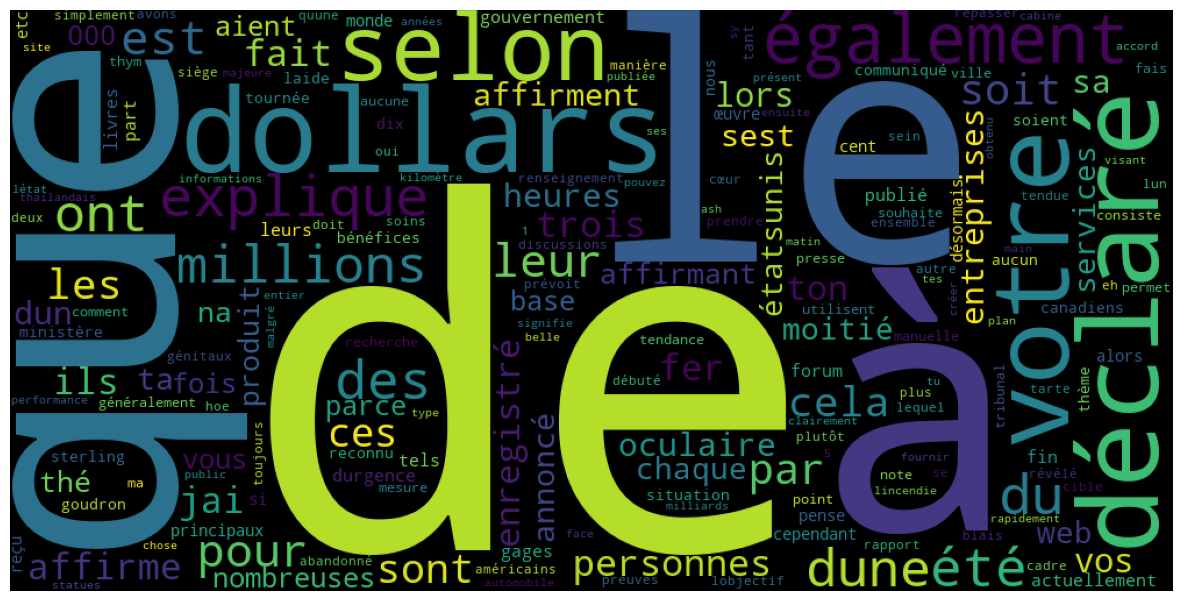

In [95]:
from wordcloud import WordCloud
wc = WordCloud(height=500, width=1000).generate_from_frequencies(difference_word_level_aws_10_percent_word_change_pedler)
#title the plot
print("Wordcloud of words added by AWS 10% modified pedler")
plt.figure(figsize=(15,8))
#remove the axis
plt.axis("off")
plt.imshow(wc)

Wordcloud of words removed by AWS 10% modified pedler


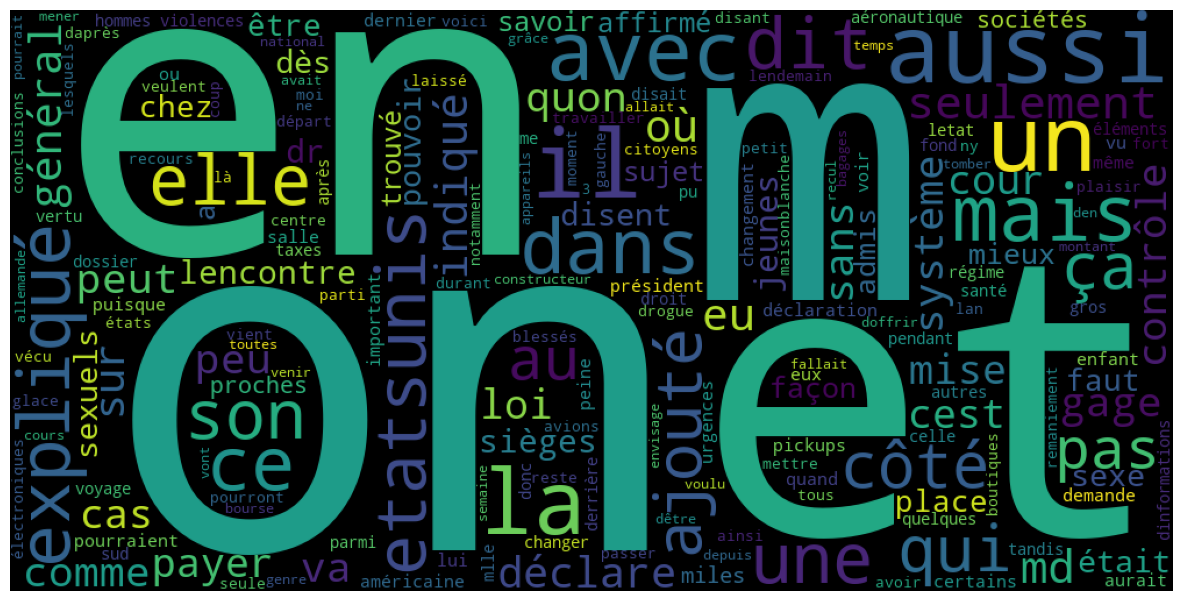

In [98]:
#lets turn all the positive values of difference_word_level_aws_10_percent_word_change_pedler to negative and vice versa
difference_word_level_aws_10_percent_word_change_pedler_negated = {}
for key, value in difference_word_level_aws_10_percent_word_change_pedler.items():
    difference_word_level_aws_10_percent_word_change_pedler_negated[key] = -value

wc = WordCloud(height=500, width=1000).generate_from_frequencies(difference_word_level_aws_10_percent_word_change_pedler_negated)
#title the plot
print("Wordcloud of words removed by AWS 10% modified pedler")
plt.figure(figsize=(15,8))
#remove the axis
plt.axis("off")
plt.imshow(wc)


Wordcloud of words added by AWS 20% modified pedler


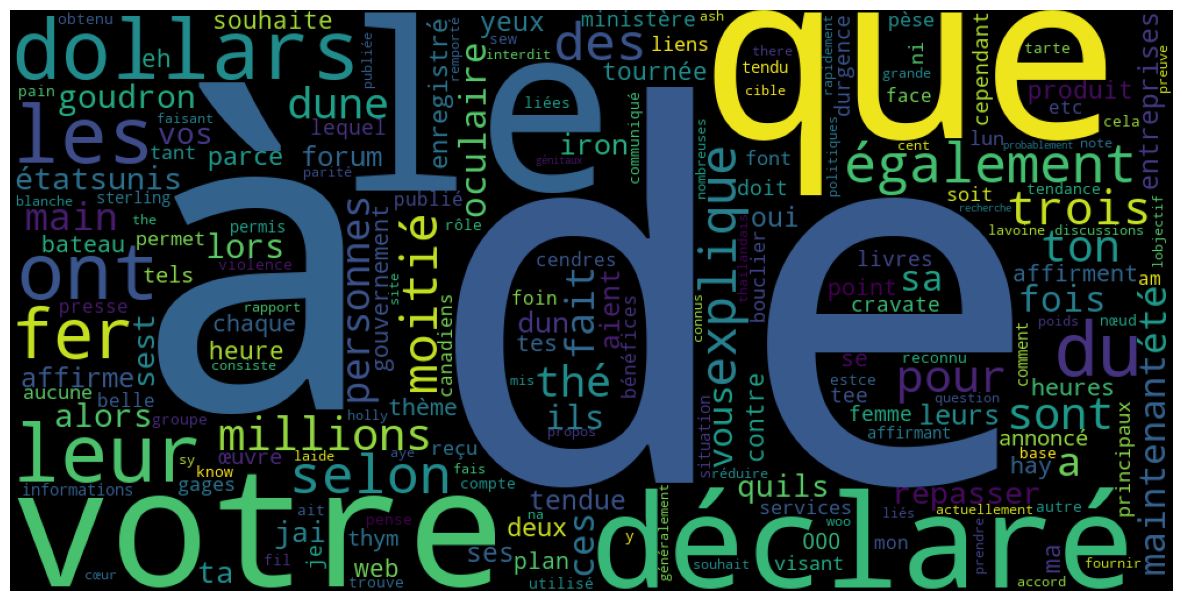

In [97]:
difference_word_level_aws_20_percent_word_change_pedler = compare_df_setence_level(aws_data_v2[1], reference_corpus_fr)
#make a word cloud
wc = WordCloud(height=500, width=1000).generate_from_frequencies(difference_word_level_aws_20_percent_word_change_pedler)
print("Wordcloud of words added by AWS 20% modified pedler")
plt.figure(figsize=(15,8))
#remove the axis
plt.axis("off")
plt.imshow(wc)

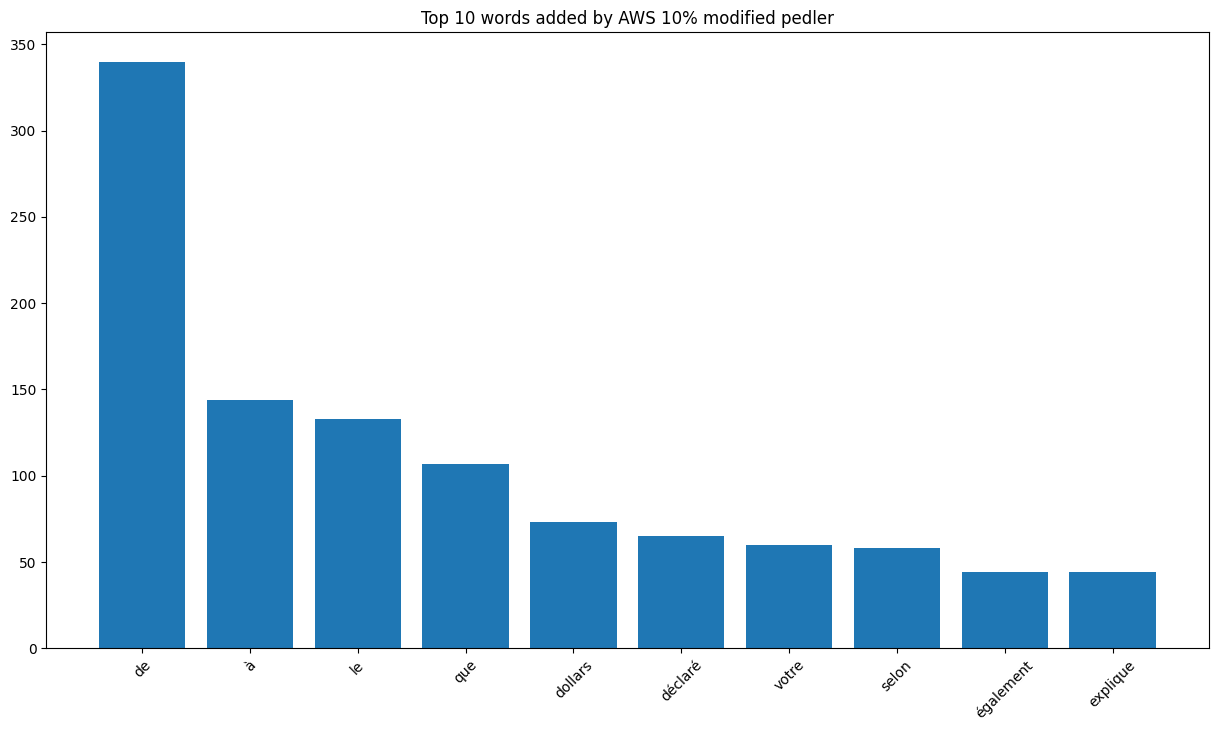

In [99]:
#lets get the top 10 highest values of difference_word_level_aws_10_percent_word_change_pedler
top_10_words_added = dict(sorted(difference_word_level_aws_10_percent_word_change_pedler.items(), key=lambda item: item[1], reverse=True)[:10])

#graph them
plt.figure(figsize=(15,8))
plt.bar(top_10_words_added.keys(), top_10_words_added.values())
plt.xticks(rotation=45)
plt.title("Top 10 words added by AWS 10% modified pedler")
plt.show()


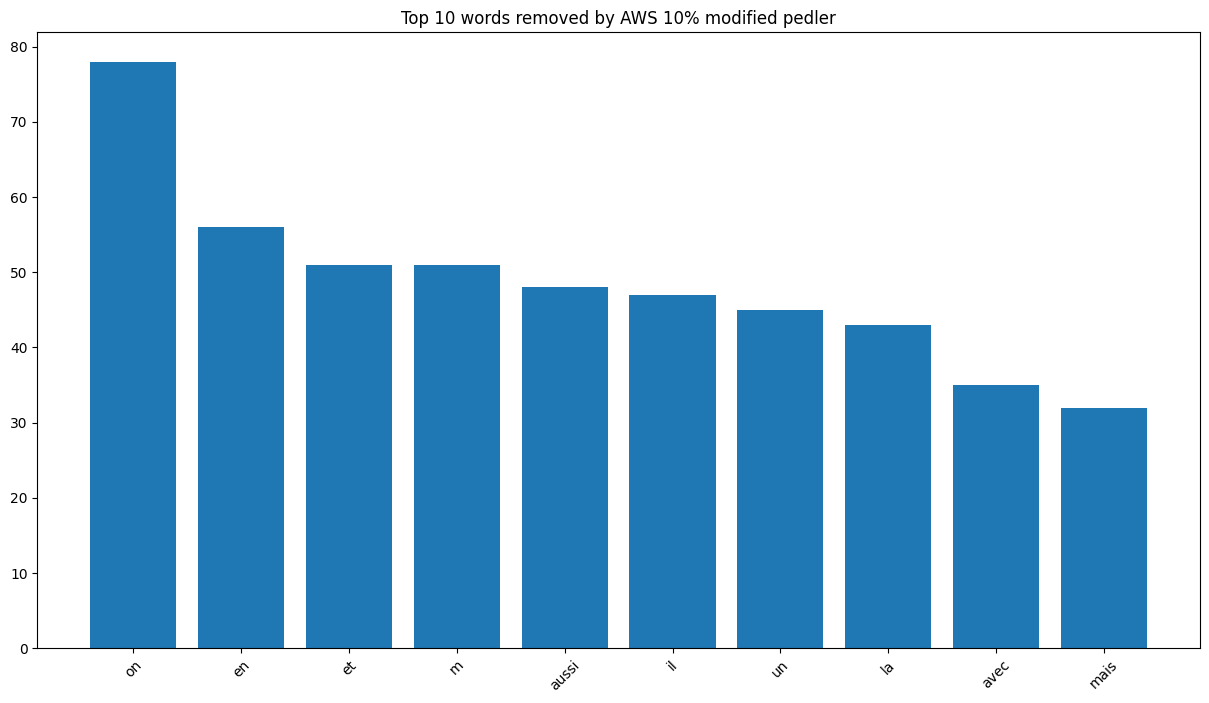

In [102]:
#lets get the 10 most removed words from difference_word_level_aws_10_percent_word_change_pedler
top_10_words_removed = dict(sorted(difference_word_level_aws_10_percent_word_change_pedler.items(), key=lambda item: item[1])[:10])

#graph them
plt.figure(figsize=(15,8))
plt.bar(top_10_words_removed.keys(), [abs(i) for i in top_10_words_removed.values()])
plt.xticks(rotation=45)
plt.title("Top 10 words removed by AWS 10% modified pedler")
plt.show()


In [103]:
#get the total amount of words in the reference corpus
total_words_in_reference_corpus = reference_corpus_fr.get_number_of_words()
print(f"Total words in reference corpus: {total_words_in_reference_corpus}")
#total number of words added by AWS 10% modified pedler
total_words_added_by_aws_10_percent_modified_pedler = aws_data_v1[2].get_number_of_words()
print(f"Total words of AWS 10% modified pedler: {total_words_added_by_aws_10_percent_modified_pedler}")

Total words in reference corpus: 69569
Total words of AWS 10% modified pedler: 71333
